In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from poisson_glm_granger import compute_granger_causality
from joblib import Parallel, delayed


In [2]:
subjects=['S1','S2','S3','S5','S6','S7','S8','S10','S11','S13','S14','S15']

def load_subject_data(conditions, subjects, data_path='./Binned'):
    """
    Preload all subject data for all conditions.
    """
    all_data = {cond: [] for cond in conditions}

    for cond in conditions:
        for subject in subjects:
            c3_data = scipy.io.loadmat(f'{data_path}/c3_binned_{cond}_subject_{subject}.mat')
            c3_data = c3_data[f'c3_binned_{cond}']

            f4_data = scipy.io.loadmat(f'{data_path}/f4_binned_{cond}_subject_{subject}.mat')
            f4_data = f4_data[f'f4_binned_{cond}']

            all_data[cond].append(np.vstack([c3_data, f4_data]))

    return all_data

In [3]:
# Preload data
all_data = load_subject_data(
    conditions=['FS', 'SS', 'GO'],
    subjects=subjects,
    data_path='./Binned'
)

In [6]:
best_windows={
    'FS': [],
    'SS': [],
    'GO': []
}
gc_matrices={
    'FS': [],
    'SS': [],
    'GO': []
}
signed_gc_matrices={
    'FS': [],
    'SS': [],
    'GO': []
}

for s_idx, subject in enumerate(subjects):
    for cond in gc_matrices:
        print(f'{subject} - {cond}')
        X=all_data[cond][s_idx]

        best_window, gc_matrix, signed_gc_matrix = compute_granger_causality(
            X, 
            window_range=(1, 20), 
            folds=10,
            n_jobs=4
        )
        best_windows[cond].append(best_window)
        gc_matrices[cond].append(gc_matrix)
        signed_gc_matrices[cond].append(signed_gc_matrix)

S1 - FS
Source 0 -> Target 0: Optimal window = 7, CV score = -0.0387
Source 1 -> Target 0: Optimal window = 7, CV score = -0.0388
Source 0 -> Target 1: Optimal window = 9, CV score = -0.0377
Source 1 -> Target 1: Optimal window = 10, CV score = -0.0377
S1 - SS


/home/bonaiuto/miniconda3/envs/poisson_glm_granger/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Source 0 -> Target 0: Optimal window = 9, CV score = -0.0396
Source 1 -> Target 0: Optimal window = 9, CV score = -0.0395
Source 0 -> Target 1: Optimal window = 2, CV score = -0.0363
Source 1 -> Target 1: Optimal window = 3, CV score = -0.0363
S1 - GO
Source 0 -> Target 0: Optimal window = 8, CV score = -0.0404
Source 1 -> Target 0: Optimal window = 8, CV score = -0.0404
Source 0 -> Target 1: Optimal window = 1, CV score = -0.0359
Source 1 -> Target 1: Optimal window = 1, CV score = -0.0359
S2 - FS
Source 0 -> Target 0: Optimal window = 10, CV score = -0.0296
Source 1 -> Target 0: Optimal window = 20, CV score = -0.0295
Source 0 -> Target 1: Optimal window = 19, CV score = -0.0393
Source 1 -> Target 1: Optimal window = 18, CV score = -0.0394
S2 - SS
Source 0 -> Target 0: Optimal window = 17, CV score = -0.0271
Source 1 -> Target 0: Optimal window = 17, CV score = -0.0270
Source 0 -> Target 1: Optimal window = 20, CV score = -0.0390
Source 1 -> Target 1: Optimal window = 20, CV score = 

Source 1 -> Target 0: Optimal window = 4, CV score = -0.0374
Source 0 -> Target 1: Optimal window = 15, CV score = -0.0344
Source 1 -> Target 1: Optimal window = 15, CV score = -0.0344
S15 - SS
Source 0 -> Target 0: Optimal window = 8, CV score = -0.0396
Source 1 -> Target 0: Optimal window = 14, CV score = -0.0396
Source 0 -> Target 1: Optimal window = 17, CV score = -0.0353
Source 1 -> Target 1: Optimal window = 15, CV score = -0.0354
S15 - GO
Source 0 -> Target 0: Optimal window = 1, CV score = -0.0388
Source 1 -> Target 0: Optimal window = 3, CV score = -0.0388
Source 0 -> Target 1: Optimal window = 5, CV score = -0.0354
Source 1 -> Target 1: Optimal window = 6, CV score = -0.0354


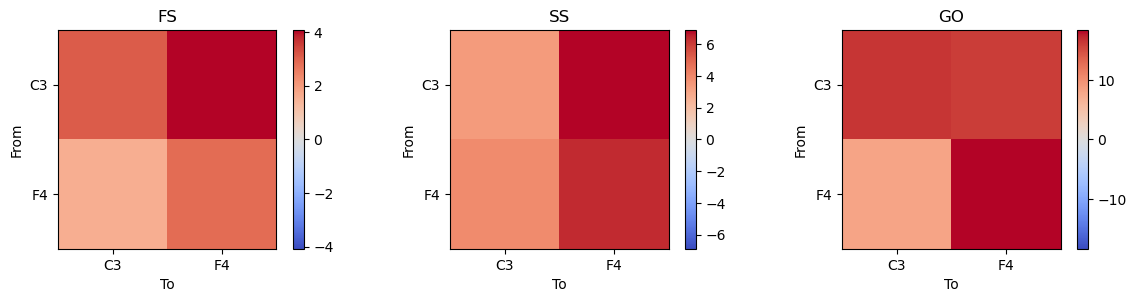

In [9]:
plt.figure(figsize=(12,3))
for cond_idx, cond in enumerate(signed_gc_matrices):
    ax=plt.subplot(1,3,cond_idx+1)
    gc_mat=np.mean(np.array(signed_gc_matrices[cond]),axis=0)
    maxabs=np.max(np.abs(gc_mat[:]))
    # Display results
    im=plt.imshow(gc_mat, cmap='coolwarm', interpolation='none', clim=[-maxabs, maxabs])
    plt.colorbar()
    plt.title(cond)
    plt.xlabel("To")
    plt.ylabel("From")
    plt.xticks([0,1])
    ax.set_xticklabels(['C3','F4'])
    plt.yticks([0,1])
    ax.set_yticklabels(['C3','F4'])
plt.tight_layout()

In [13]:
def shuffle_data(data):
    """
    Shuffle trials for all neurons in the data array.
    
    Parameters:
    ----------
    data : ndarray
        The input data array of shape (neurons, trials, time_steps).
    
    Returns:
    -------
    ndarray
        A shuffled version of the input data.
    """
    shuffled_data = data.copy()
    neurons, trials, time_steps = shuffled_data.shape

    for neuron in range(neurons):
        for trial in range(trials):
            np.random.shuffle(shuffled_data[neuron, trial, :])  # Shuffle spikes across time
    return shuffled_data



def permutation_test(best_windows, gc_matrices, signed_gc_matrices, all_data, conditions, n_permutations=1000, n_jobs=-1):
    """
    Perform a permutation test for Granger causality analysis.

    Parameters:
    ----------
    best_windows : dict
        Dictionary with optimal lag values for each subject and condition.
    gc_matrices : dict
        Dictionary with GC matrices for each subject and condition.
    signed_gc_matrices : dict
        Dictionary with signed GC matrices for each subject and condition.
    all_data : dict
        Preloaded subject data for all conditions.
    conditions : list
        List of experimental conditions.
    n_permutations : int, optional
        Number of permutations to perform. Default is 1000.
    n_jobs : int, optional
        Number of parallel jobs. Default is -1 (all available cores).

    Returns:
    -------
    dict
        Null distributions for each condition.
    dict
        P-values for each connection in each condition.
    """
    shuffled_results = {cond: [] for cond in conditions}
    neurons = gc_matrices[conditions[0]][0].shape[0]

    def process_permutation(perm_idx):
        """
        Process a single permutation in parallel.
        """
        perm_results = {cond: [] for cond in conditions}

        for cond in conditions:
            for s_idx, subject_data in enumerate(all_data[cond]):
                # Create a shuffled copy of the data
                shuffled_X = shuffle_data(subject_data)

                # Compute Granger causality matrix
                _, gc_matrix, _ = compute_granger_causality(
                    shuffled_X, 
                    n_jobs=1,  # Single job for this computation
                    pairwise_windows=best_windows[cond][s_idx]
                )
                perm_results[cond].append(gc_matrix)

        # Aggregate across subjects
        for cond in conditions:
            perm_results[cond] = np.mean(perm_results[cond], axis=0)

        return perm_results

    # Parallelize permutations
    all_permutations = Parallel(n_jobs=n_jobs)(
        delayed(process_permutation)(perm) for perm in range(n_permutations)
    )

    # Aggregate null distributions
    null_distributions = {cond: np.zeros((n_permutations, neurons, neurons)) for cond in conditions}

    for perm_idx, perm_result in enumerate(all_permutations):
        for cond in conditions:
            null_distributions[cond][perm_idx] = perm_result[cond]

    # Compute p-values
    p_values = {}
    for cond in conditions:
        null_mean = np.mean(null_distributions[cond], axis=0)
        observed = np.mean(gc_matrices[cond], axis=0)

        p_values[cond] = (np.sum(null_distributions[cond] >= observed, axis=0) + 1) / (n_permutations + 1)

    return null_distributions, p_values


# Run permutation test
null_distributions, p_values = permutation_test(
    best_windows,
    gc_matrices,
    signed_gc_matrices,
    all_data=all_data,
    conditions=['FS', 'SS', 'GO'],
    n_permutations=1000,
    n_jobs=4
)

# Inspect p-values
for cond, p_val_matrix in p_values.items():
    print(f"P-values for condition {cond}:")
    print(p_val_matrix)

# Visualize null distributions and observed GC
for cond in null_distributions:
    plt.figure(figsize=(8, 6))
    plt.title(f"Null Distribution vs Observed GC for {cond}")
    plt.hist(null_distributions[cond].flatten(), bins=50, alpha=0.7, label="Null Distribution")
    plt.axvline(
        x=np.mean(gc_matrices[cond]), color='red', linestyle='dashed', linewidth=2, label="Observed GC"
    )
    plt.legend()
    plt.xlabel("Granger Causality Value")
    plt.ylabel("Frequency")
    plt.show()


/home/bonaiuto/miniconda3/envs/poisson_glm_granger/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Process LokyProcess-74:
Traceback (most recent call last):
  File "/home/bonaiuto/miniconda3/envs/poisson_glm_granger/lib/python3.12/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/bonaiuto/miniconda3/envs/poisson_glm_granger/lib/python3.12/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/bonaiuto/miniconda3/envs/poisson_glm_granger/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py", line 501, in _process_worker
    with worker_exit_lock:
         ^^^^^^^^^^^^^^^^
  File "/home/bonaiuto/miniconda3/envs/poisson_glm_granger/lib/python3.12/site-packages/joblib/externals/loky/backend/synchronize.p